In [30]:
from openpyxl import load_workbook
from datetime import time, timedelta

# Map trung tâm với thành phố nội thành
CENTER_CITY_MAP = {
    4: 'Thành phố Hà Nội',
    2: 'Thành phố Hồ Chí Minh',
    3: 'Thành phố Đà Nẵng',
}


def is_inner_city(city, center):
    # xác định đơn nội thành (True) hay ngoại thành (False)
    if city is None or center is None:
        return None

    try:
        center_int = int(center)
    except Exception:
        return None

    main_city = CENTER_CITY_MAP.get(center_int)
    if main_city is None:
        return None

    return city == main_city


def classify_inner_case(created_at):
    # phân loại đơn nội thành theo giờ đặt
    t = created_at.time()

    if t < time(10, 0):
        return 'inner_case1'
    elif t < time(16, 0):
        return 'inner_case2'
    else:
        return 'inner_case3'


def check_inner_case_sla(case_code, created_at, approved_at, packed_at, completed_at):
    created_date = created_at.date()

    if case_code == 'inner_case1':
        # trước 10h
        return (
            approved_at.date() == created_date
            and approved_at.time() <= time(12, 0)
            and packed_at.date() == created_date
            and packed_at.time() <= time(14, 0)
            and completed_at.date() == created_date
        )

    elif case_code == 'inner_case2':
        # 10h - 16h
        next_date = created_date + timedelta(days=1)
        return (
            approved_at.date() == created_date
            and approved_at.time() <= time(17, 0)
            and packed_at.date() == next_date
            and packed_at.time() <= time(10, 0)
            and completed_at.date() == next_date
            and completed_at.time() <= time(10, 0)
        )

    elif case_code == 'inner_case3':
        # sau 16h
        next_date = created_date + timedelta(days=1)
        return (
            approved_at.date() == next_date
            and approved_at.time() <= time(9, 30)
            and packed_at.date() == next_date
            and packed_at.time() <= time(12, 0)
            and completed_at.date() == next_date
            and completed_at.time() <= time(16, 0)
        )

    return False


def check_outer_sla(created_at, approved_at, packed_at, completed_at):
    # SLA đơn ngoại thành
    return (
        (approved_at - created_at) <= timedelta(hours=24)
        and (packed_at - approved_at) <= timedelta(hours=4)
        and (completed_at - packed_at) <= timedelta(hours=24)
    )


def analyze_file(filename, sheet_name='Sheet1'):
    wb = load_workbook(filename, data_only=True)
    ws = wb[sheet_name]

    stats = {
        'inner_case1': {'total': 0, 'on_time': 0},
        'inner_case2': {'total': 0, 'on_time': 0},
        'inner_case3': {'total': 0, 'on_time': 0},
        'outer_case': {'total': 0, 'on_time': 0},
    }
    stats_center_city = {}

    for row in ws.iter_rows(min_row=2, values_only=True):
        if all(v is None for v in row):
            continue

        created_at, approved_at, packed_at, completed_at, city, center = row[:6]

        if (
            created_at is None or approved_at is None or
            packed_at is None or completed_at is None or
            city is None or center is None
        ):
            continue

        inner_flag = is_inner_city(city, center)
        if inner_flag is None:
            continue

        if inner_flag:
            # lọc 3 TH nội thành
            case_code = classify_inner_case(created_at)
            stats[case_code]['total'] += 1
            on_time = check_inner_case_sla(case_code, created_at, approved_at, packed_at, completed_at)
            if on_time:
                stats[case_code]['on_time'] += 1
        else:
            case_code = 'outer_case'
            stats[case_code]['total'] += 1
            on_time = check_outer_sla(created_at, approved_at, packed_at, completed_at)
            if on_time:
                stats[case_code]['on_time'] += 1

        # Thống kê theo (center, city)
        key = (center, city)
        if key not in stats_center_city:
            stats_center_city[key] = {'total': 0, 'on_time': 0}
        stats_center_city[key]['total'] += 1
        if on_time:
            stats_center_city[key]['on_time'] += 1

    case_names = {
        'inner_case1': 'Nội thành - Đặt trước 10h',
        'inner_case2': 'Nội thành - Đặt 10h-16h',
        'inner_case3': 'Nội thành - Đặt sau 16h',
        'outer_case': 'Ngoại thành',
    }

    for code, info in stats.items():
        total = info['total']
        late = total - info['on_time']
        # late = info['on_time']
        print(f"=== {case_names[code]} ===")
        print(f"  Tổng đơn : {total}")
        print(f"  Trễ SLA  : {late}")
        print()

    print("=== THỐNG KÊ THEO CENTER & CITY ===")
    for (center, city), info in stats_center_city.items():
        total = info['total']
        late = total - info['on_time']
        print(f"Center {center} - {city}: Tổng {total} đơn, Trễ SLA {late} đơn")

    return stats, stats_center_city


if __name__ == "__main__":
    file_path = "Test.xlsx"
    stats,stats_center_city = analyze_file(file_path)
    print(stats)


=== Nội thành - Đặt trước 10h ===
  Tổng đơn : 9
  Trễ SLA  : 9

=== Nội thành - Đặt 10h-16h ===
  Tổng đơn : 5
  Trễ SLA  : 5

=== Nội thành - Đặt sau 16h ===
  Tổng đơn : 2
  Trễ SLA  : 2

=== Ngoại thành ===
  Tổng đơn : 13
  Trễ SLA  : 12

=== THỐNG KÊ THEO CENTER & CITY ===
Center 4 - Thành phố Hà Nội: Tổng 7 đơn, Trễ SLA 7 đơn
Center 4 - Tỉnh Tuyên Quang: Tổng 2 đơn, Trễ SLA 2 đơn
Center 4 - Tỉnh Thái Nguyên: Tổng 2 đơn, Trễ SLA 2 đơn
Center 3 - Thành phố Đà Nẵng: Tổng 5 đơn, Trễ SLA 5 đơn
Center 3 - Tỉnh Quảng Ngãi: Tổng 2 đơn, Trễ SLA 1 đơn
Center 3 - Tỉnh Quảng Trị: Tổng 1 đơn, Trễ SLA 1 đơn
Center 2 - Thành phố Cần Thơ: Tổng 3 đơn, Trễ SLA 3 đơn
Center 2 - Tỉnh Khánh Hòa: Tổng 3 đơn, Trễ SLA 3 đơn
Center 2 - Thành phố Hồ Chí Minh: Tổng 4 đơn, Trễ SLA 4 đơn
{'inner_case1': {'total': 9, 'on_time': 0}, 'inner_case2': {'total': 5, 'on_time': 0}, 'inner_case3': {'total': 2, 'on_time': 0}, 'outer_case': {'total': 13, 'on_time': 1}}


In [31]:
import pandas as pd
import matplotlib.pyplot as plt
stats, stats_center_city=analyze_file(file_path)
case_names = {
    'inner_case1': 'Nội thành - Đặt trước 10h',
    'inner_case2': 'Nội thành - Đặt 10h-16h',
    'inner_case3': 'Nội thành - Đặt sau 16h',
    'outer_case': 'Ngoại thành',
}
print(stats_center_city)
rows_case = []
for code, info in stats.items():
    total = info['total']
    on_time = info['on_time']
    late = total - on_time

    # late = info['on_time']
    # on_time = total - late
    # late = on_time
    rows_case.append({
        "case_code": code,
        "case_name": case_names[code],
        "total": total,
        "on_time": on_time,
        "late": late,
    })

df_case = pd.DataFrame(rows_case)
print("\n=== DataFrame theo case ===")
print(df_case)

#thống kê theo Center & City
rows_cc = []
for (center, city), info in stats_center_city.items():
    total = info['total']
    on_time = info['on_time']
    late = total - on_time

    # late = info['on_time']
    # on_time = total - late
    rows_cc.append({
        "center": center,
        "city": city,
        "total": total,
        "on_time": on_time,
        "late": late,
    })

df_center_city = pd.DataFrame(rows_cc)
print("\n=== DataFrame theo Center & City ===")
print(df_center_city)

#thống kê theo từng Center 
df_center = (
    df_center_city
    .groupby("center")[["total", "late", "on_time"]]
    .sum()
    .reset_index()
)
print("\n=== DataFrame theo Center ===")

=== Nội thành - Đặt trước 10h ===
  Tổng đơn : 9
  Trễ SLA  : 9

=== Nội thành - Đặt 10h-16h ===
  Tổng đơn : 5
  Trễ SLA  : 5

=== Nội thành - Đặt sau 16h ===
  Tổng đơn : 2
  Trễ SLA  : 2

=== Ngoại thành ===
  Tổng đơn : 13
  Trễ SLA  : 12

=== THỐNG KÊ THEO CENTER & CITY ===
Center 4 - Thành phố Hà Nội: Tổng 7 đơn, Trễ SLA 7 đơn
Center 4 - Tỉnh Tuyên Quang: Tổng 2 đơn, Trễ SLA 2 đơn
Center 4 - Tỉnh Thái Nguyên: Tổng 2 đơn, Trễ SLA 2 đơn
Center 3 - Thành phố Đà Nẵng: Tổng 5 đơn, Trễ SLA 5 đơn
Center 3 - Tỉnh Quảng Ngãi: Tổng 2 đơn, Trễ SLA 1 đơn
Center 3 - Tỉnh Quảng Trị: Tổng 1 đơn, Trễ SLA 1 đơn
Center 2 - Thành phố Cần Thơ: Tổng 3 đơn, Trễ SLA 3 đơn
Center 2 - Tỉnh Khánh Hòa: Tổng 3 đơn, Trễ SLA 3 đơn
Center 2 - Thành phố Hồ Chí Minh: Tổng 4 đơn, Trễ SLA 4 đơn
{(4, 'Thành phố Hà Nội'): {'total': 7, 'on_time': 0}, (4, 'Tỉnh Tuyên Quang'): {'total': 2, 'on_time': 0}, (4, 'Tỉnh Thái Nguyên'): {'total': 2, 'on_time': 0}, (3, 'Thành phố Đà Nẵng'): {'total': 5, 'on_time': 0}, (3, 'Tỉnh

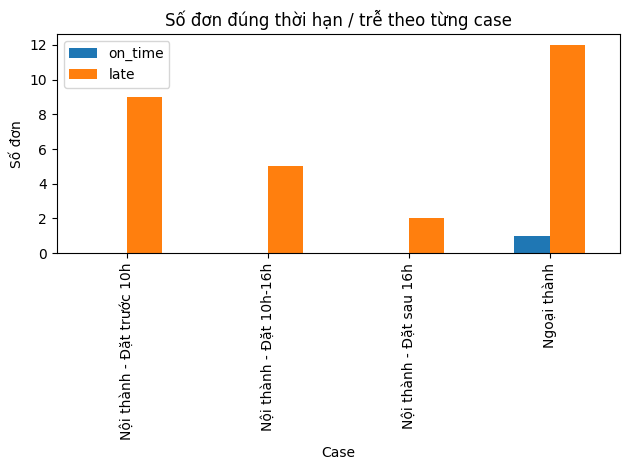

In [32]:
df_case.plot(kind="bar", x="case_name", y=["on_time", "late"])
plt.title("Số đơn đúng thời hạn / trễ theo từng case")
plt.xlabel("Case")
plt.ylabel("Số đơn")
plt.tight_layout()
plt.show()

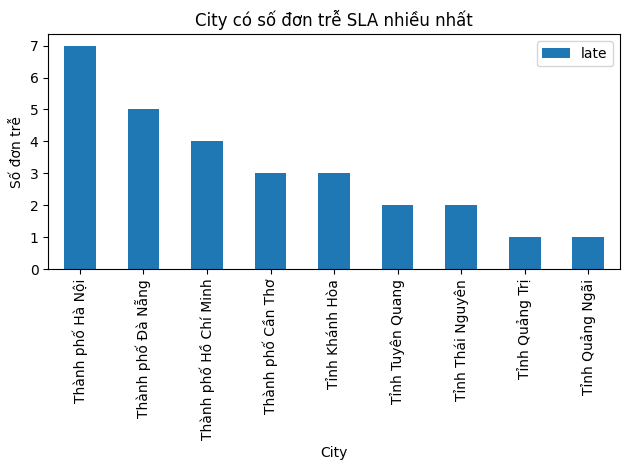

In [33]:
df_city = (
        df_center_city
        .groupby("city")[["total", "late", "on_time"]]
        .sum()
        .reset_index()
    )
df_city = df_city.sort_values("late", ascending=False)

df_city.plot(kind="bar", x="city", y="late")
plt.title("City có số đơn trễ SLA nhiều nhất")
plt.xlabel("City")
plt.ylabel("Số đơn trễ")
plt.tight_layout()
plt.show()

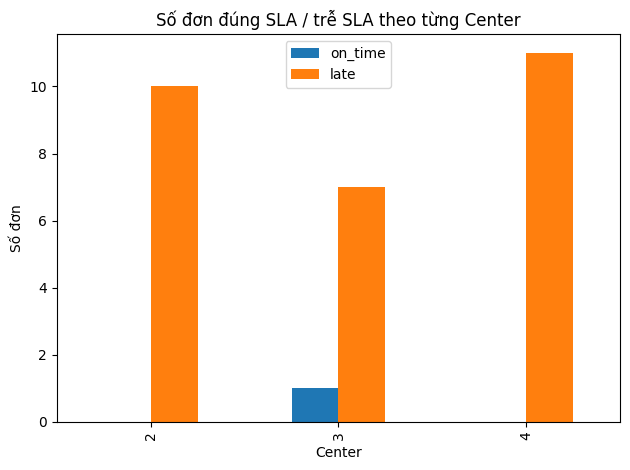

In [34]:
df_center.plot(kind="bar", x="center", y=["on_time", "late"])
plt.title("Số đơn đúng SLA / trễ SLA theo từng Center")
plt.xlabel("Center")
plt.ylabel("Số đơn")
plt.tight_layout()
plt.show()